In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

import secret_info

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score,ConfusionMatrixDisplay
from matplotlib import pyplot as plt

import xgboost as xgb
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

from tpot import TPOTClassifier


/home/erkahraman/.local/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# Database Connection
client = MongoClient(secret_info.database_connection)
db = client["Main"]
collection = db["flows"]

In [3]:
# All ICMP Data
df = pd.DataFrame.from_records(list(collection.find({"application_name":"ICMP"})))

In [4]:
df

,_id,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,bidirectional_first_seen,bidirectional_last_seen
0,63ed90b61cd0194aba2e5a8a,68,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-16 02:00:02.770,2023-02-16 02:00:11.256
1,63ed934a18cd8866c592b72a,69,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-16 02:11:03.231,2023-02-16 02:11:03.234
2,63ed95dd9d271082351e98d0,45,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-16 02:22:02.558,2023-02-16 02:22:02.562
3,63ed9871e07efbcfe2a577f0,100,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-16 02:33:02.425,2023-02-16 02:33:02.427
4,63ed9b06707a0a663dd1595c,8,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-16 02:44:02.437,2023-02-16 02:44:02.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,6407853e15f5cdd610251dcc,149,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.61,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-03-07 18:33:49.043,2023-03-07 18:33:49.646
1632,6407853e15f5cdd610251de9,178,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.61,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-03-07 18:34:19.994,2023-03-07 18:34:19.997
1633,6407853e15f5cdd610251e5c,293,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.61,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-03-07 18:34:56.646,2023-03-07 18:36:01.196
1634,6407853e15f5cdd610251ed2,411,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.61,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-03-07 18:37:23.496,2023-03-07 18:38:24.701


In [5]:
# Attack & Bening Data
data_attack = df.query("src_ip == '192.168.1.51' and dst_ip == '192.168.1.49'")
data_clean = df.query("(src_ip != '192.168.1.51' and dst_ip != '192.168.1.49') and (dst_ip != '192.168.1.51' and src_ip != '192.168.1.49')")

In [6]:
data_attack

,_id,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,bidirectional_first_seen,bidirectional_last_seen
548,63f66634486c1834b6632444,127,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-22 18:59:12.594,2023-02-22 18:59:20.136
560,63f67316b8b1efb320d388e8,280,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-22 19:48:03.191,2023-02-22 19:48:07.218
561,63f67316b8b1efb320d388f9,297,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-22 19:48:49.299,2023-02-22 19:48:51.301
562,63f67316b8b1efb320d38936,358,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-22 19:49:33.401,2023-02-22 19:49:35.413
563,63f67442f8ce2599a311f250,8,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-22 19:50:17.488,2023-02-22 19:50:19.502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,63f93146f1b1cdda89d1da76,148,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-24 21:40:02.554,2023-02-24 21:49:59.354
1456,63f9339de36ec538e0404d00,296,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-24 21:50:03.377,2023-02-24 21:59:58.217
1457,63f935f683f448117ec156bd,152,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-24 22:00:02.245,2023-02-24 22:09:58.998
1459,63f9384eef16c01852cd88ab,254,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.49,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-24 22:10:03.032,2023-02-24 22:19:59.999


In [7]:
# Marking & Concat
data_attack["label"] = 1
data_clean["label"] = 0
data = pd.concat([data_clean, data_attack], axis=0)

/tmp/ipykernel_37159/1032501543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_attack["label"] = 1
/tmp/ipykernel_37159/1032501543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["label"] = 0


# Korelasyon

In [8]:
pd.set_option('display.max_rows', 500)
korelasyon = data.loc[:, ['label', '_id', 'id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'src_port', 'dst_ip', 'dst_mac', 'dst_oui', 'dst_port', 'protocol', 'ip_version', 'vlan_id',
 'tunnel_id', 'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms', 'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
 'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms', 'dst2src_duration_ms', 'dst2src_packets',
 'dst2src_bytes', 'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps',
 'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
 'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
 'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms', 'bidirectional_syn_packets', 'bidirectional_cwr_packets', 'bidirectional_ece_packets', 'bidirectional_urg_packets', 'bidirectional_ack_packets',
 'bidirectional_psh_packets', 'bidirectional_rst_packets', 'bidirectional_fin_packets', 'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets', 'src2dst_urg_packets',
 'src2dst_ack_packets', 'src2dst_psh_packets', 'src2dst_rst_packets', 'src2dst_fin_packets', 'dst2src_syn_packets', 'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
 'dst2src_ack_packets', 'dst2src_psh_packets', 'dst2src_rst_packets', 'dst2src_fin_packets', 'application_name', 'application_category_name', 'application_is_guessed', 'application_confidence',
 'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type', 'bidirectional_first_seen', 'bidirectional_last_seen']].corr().abs()

/tmp/ipykernel_37159/3030337693.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type', 'bidirectional_first_seen', 'bidirectional_last_seen']].corr().abs()


In [9]:
korelasyon.style.background_gradient(cmap='coolwarm')

/home/erkahraman/.local/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/erkahraman/.local/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [10]:
korelasyon_iliskili = korelasyon["label"].where(korelasyon["label"] > 0).dropna(how="all")
korelasyon_iliskili.index

Index(['label', 'id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps',
       'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
       'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms',
       'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms',
       'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_st

In [11]:
'''['label','bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']'''

"['label','bidirectional_duration_ms',\n       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',\n       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',\n       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',\n       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',\n       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',\n       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',\n       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']"

In [12]:
korelasyon_secim = data.loc[:, ['label',
       'src2dst_min_ps',
       'src2dst_mean_ps','dst2src_min_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'dst2src_min_piat_ms','dst2src_max_piat_ms']].corr().abs()
korelasyon_secim.style.background_gradient(cmap='coolwarm')

,label,src2dst_min_ps,src2dst_mean_ps,dst2src_min_ps,dst2src_stddev_ps,dst2src_max_ps,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,dst2src_min_piat_ms,dst2src_max_piat_ms
label,1.000000,0.398003,0.168175,0.615086,0.437155,0.811108,0.284749,0.108998,0.164106,0.929488,0.344038
src2dst_min_ps,0.398003,1.000000,0.294178,0.442237,0.553433,0.265023,0.123935,0.041832,0.081083,0.375526,0.131609
src2dst_mean_ps,0.168175,0.294178,1.000000,0.367692,0.242351,0.630082,0.039984,0.020096,0.015819,0.161755,0.011112
dst2src_min_ps,0.615086,0.442237,0.367692,1.000000,0.068147,0.556013,0.174378,0.067646,0.098059,0.575640,0.261895
dst2src_stddev_ps,0.437155,0.553433,0.242351,0.068147,1.000000,0.670879,0.128222,0.049399,0.074146,0.417502,0.108107
dst2src_max_ps,0.811108,0.265023,0.630082,0.556013,0.670879,1.000000,0.233548,0.090388,0.133228,0.765327,0.273529
src2dst_min_piat_ms,0.284749,0.123935,0.039984,0.174378,0.128222,0.233548,1.000000,0.713088,0.071510,0.267502,0.103980
src2dst_mean_piat_ms,0.108998,0.041832,0.020096,0.067646,0.049399,0.090388,0.713088,1.000000,0.616956,0.123080,0.043861
src2dst_stddev_piat_ms,0.164106,0.081083,0.015819,0.098059,0.074146,0.133228,0.071510,0.616956,1.000000,0.115635,0.047805
dst2src_min_piat_ms,0.929488,0.375526,0.161755,0.575640,0.417502,0.765327,0.267502,0.123080,0.115635,1.000000,0.361460


In [13]:
# Correlation Features 
X = data.loc[:, ['src2dst_min_ps',
       'src2dst_mean_ps','dst2src_min_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'dst2src_min_piat_ms','dst2src_max_piat_ms']]
y = data["label"]

In [14]:
# Random Forest Model with Correlation Feautres
rfc = RandomForestClassifier(random_state=42,
                             n_jobs=-1,
                             n_estimators=600,
                             min_samples_leaf=1,
                             oob_score=True,
                             bootstrap=True,
                             max_depth=None)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [16]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600, n_jobs=-1, oob_score=True,
                       random_state=42)

In [17]:
siniflar = ["bening", "suspect"]

In [18]:
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       0.99      0.99      0.99       110

    accuracy                           0.99       323
   macro avg       0.99      0.99      0.99       323
weighted avg       0.99      0.99      0.99       323



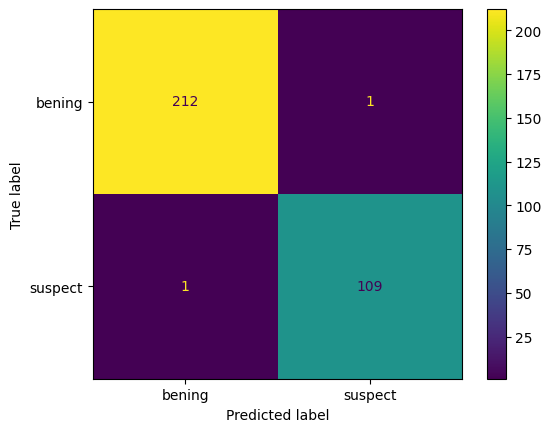

In [19]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bening", "suspect"])
cm_display.plot()

In [20]:
# XGBoost Model with Correlation Features
xgb = XGBClassifier(random_state = 42,
                    nthread=-1,
                    booster='gbtree',
                    objective='binary:logistic',
                    n_jobs=-1,
                    max_depth=12,
                    learning_rate=0.1,
                    n_estimators=600)

In [21]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [22]:
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      0.99      1.00       110

    accuracy                           1.00       323
   macro avg       1.00      1.00      1.00       323
weighted avg       1.00      1.00      1.00       323



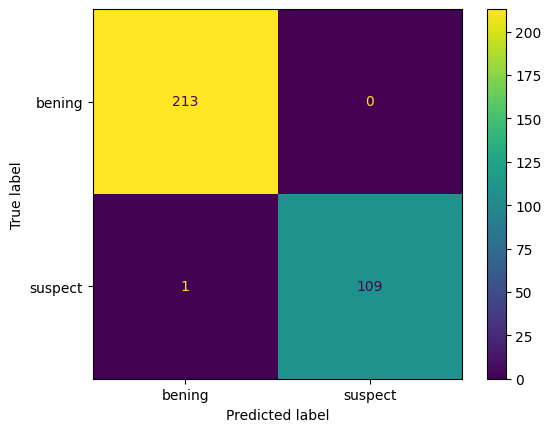

In [23]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bening", "suspect"])
cm_display.plot()

In [24]:
# Random Forest Model with All Numeric Features
X = data.loc[:, ['bidirectional_duration_ms','bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']]
y = data["label"]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.01, random_state=42, stratify=y)

In [26]:
rfc = RandomForestClassifier(random_state=42,
                             n_jobs=-1,
                             n_estimators=600,
                             min_samples_leaf=1,
                             oob_score=True,
                             bootstrap=True,
                             max_depth=None)

In [27]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600, n_jobs=-1, oob_score=True,
                       random_state=42)

In [28]:
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.86      1.00      0.92         6

    accuracy                           0.94        17
   macro avg       0.93      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



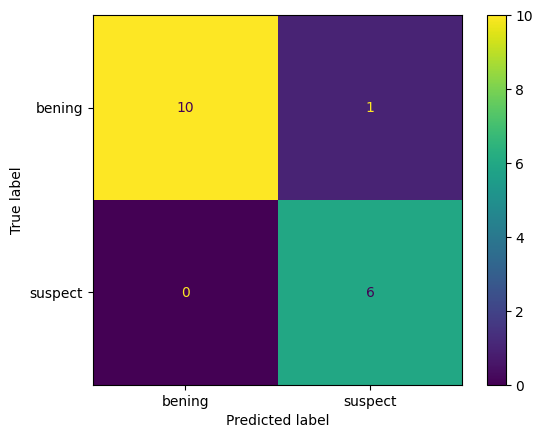

In [29]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bening", "suspect"])
cm_display.plot()

In [30]:
#XGBoost Model with All Numeric Features
xgb = XGBClassifier(random_state = 42,
                    nthread=-1,
                    booster='gbtree',
                    objective='binary:logistic',
                    n_jobs=-1,
                    max_depth=12,
                    learning_rate=0.1,
                    n_estimators=600)

In [31]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [32]:
y_pred = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



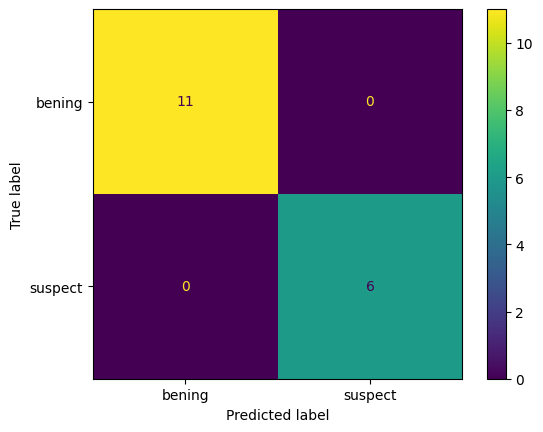

In [33]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bening", "suspect"])
cm_display.plot()

In [35]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

#Bayes Optimization
def xgb_cv(max_depth, learning_rate, n_estimators, min_child_weight, subsample, gamma, colsample_bytree, reg_alpha, reg_lambda, scale_pos_weight):
    params = {
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'n_jobs': -1,
        'booster':'gbtree',
        'scale_pos_weight': scale_pos_weight
    }
    clf = xgb.XGBClassifier(**params)
   
    return cross_val_score(clf, X, y, scoring='roc_auc', cv=5).mean()

# Params
pbounds = {
    'max_depth': (1, 20),
    'learning_rate': (0.01, 0.1),
    'n_estimators': (50, 800),
    'min_child_weight': (0.1, 20.0),
    'subsample': (0.1, 1.0),
    'gamma': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'reg_alpha': (0.1, 20.0),
    'reg_lambda': (0.1, 20.0),
    'scale_pos_weight': (0.1, 1)
}

# Bayesian optimization
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=1
)

optimizer.maximize(init_points=10, n_iter=80)

# Best Params
print(f"En iyi parametreler: {optimizer.max['params']}")

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9994    | 0.4753    | 0.7483    | 0.01001   | 6.744     | 3.02      | 119.3     | 3.807     | 6.977     | 0.4571    | 0.5849    |
| 2         | 0.9993    | 0.4773    | 0.7167    | 0.0284    | 17.68     | 0.645     | 552.9     | 8.404     | 11.22     | 0.2263    | 0.2783    |
| 3         | 0.9986    | 0.8207    | 0.9714    | 0.03821   | 14.15     | 17.54     | 721.0     | 1.792     | 0.8772    | 0.2528    | 0.8903    |
| 4         | 0.9913    | 0.1885    | 0.479     | 0.09621   | 11.13     | 13.87     | 286.6     | 13.76     | 16.71     | 0.1165    | 0.7751    |
| 5         | 0.998     | 0.99      | 0.7733    | 0.03524   | 16.0      | 2.154     | 385.9     | 18.18     | 5.943     | 0.

In [36]:
# Best Features from Bayes Optimizations
xgb = XGBClassifier(random_state = 42,
                    nthread=-1,
                    booster='gbtree',
                    objective='binary:logistic',
                    n_jobs=-1,
                    max_depth=20,
                    learning_rate=0.1,
                    n_estimators=203,
                    min_child_weight = 20,
                    colsample_bytree= 1,
                    gamma=0.1,
                    reg_alpha=20,
                    reg_lambda=0.1,
                    scale_pos_weight=1,
                    subsample=0.1)

In [37]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.1, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              n_estimators=203, n_jobs=-1, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [38]:
# Test Data İmport

test_df = pd.DataFrame.from_records(list(collection.find({"application_name":"ICMP", "src_ip" :'192.168.1.51', "dst_ip": '192.168.1.54'})))

In [39]:
test_df["predict"] = xgb.predict(test_df.loc[:,['bidirectional_duration_ms','bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']])

In [40]:
test_df

,_id,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,bidirectional_first_seen,bidirectional_last_seen,predict
0,63fa9585e91d3b4849d6ab16,66,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:00:37.505,2023-02-25 23:00:39.507,1
1,63fa9585e91d3b4849d6ab40,108,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:01:31.897,2023-02-25 23:01:33.898,1
2,63fa9585e91d3b4849d6abb1,221,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:05:19.627,2023-02-25 23:05:21.629,1


In [41]:
# Test Data İmport

test_df = pd.DataFrame.from_records(list(collection.find({"application_name":"ICMP"})))

In [42]:
test_df = test_df.query("bidirectional_first_seen > '2023-02-25 23:00:37.505'")
'''#test_df["predict"] = xgb.predict(test_df.loc[:,['bidirectional_duration_ms','bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']])'''
test_df

,_id,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,bidirectional_first_seen,bidirectional_last_seen
1496,63fa9585e91d3b4849d6ab3a,102,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:00:59.121,2023-02-25 23:01:26.659
1497,63fa9585e91d3b4849d6ab40,108,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:01:31.897,2023-02-25 23:01:33.898
1498,63fa9585e91d3b4849d6abae,218,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:05:07.980,2023-02-25 23:05:07.980
1499,63fa9585e91d3b4849d6abb1,221,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:05:19.627,2023-02-25 23:05:21.629
1500,63fa9a36ee265a6391ff6679,198,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:21:02.409,2023-02-25 23:21:02.410
1501,63fa9c8e1083fd6bef0646b0,269,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:31:02.775,2023-02-25 23:31:02.777
1502,63fa9c8e1083fd6bef0646c0,285,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,0,35.227.203.39,6c:e8:73:9b:38:48,6c:e8:73,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:31:06.271,2023-02-25 23:31:06.271
1503,63fa9ee68bbfdd8a78d23df2,200,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:41:02.780,2023-02-25 23:41:02.785
1504,63faa13e167085e903237b96,212,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:51:02.821,2023-02-25 23:51:02.824
1505,63fb409e7ea3ab1a65e90c99,93,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,Network,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-26 00:01:02.976,2023-02-26 00:01:02.977


In [43]:
# TPOT Model
tpot = TPOTClassifier(generations=10, population_size=100, verbosity=2, random_state=42)
tpot.fit(X, y)

                                                                               
Generation 1 - Current best internal CV score: 0.9981385689287157
                                                                               
Generation 2 - Current best internal CV score: 0.998759686941138
                                                                               
Generation 3 - Current best internal CV score: 0.998759686941138
                                                                               
Generation 4 - Current best internal CV score: 0.998759686941138
                                                                               
Generation 5 - Current best internal CV score: 0.998759686941138
                                                                               
Generation 6 - Current best internal CV score: 0.998759686941138
                                                                               
Generation 7 - Current best internal CV score: 0.

TPOTClassifier(generations=10, random_state=42, verbosity=2)

In [44]:
accuracy = tpot.score(X_test, y_test)
print("Test seti doğruluğu:", accuracy)

Test seti doğruluğu: 1.0


/home/erkahraman/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


In [45]:
tpot.export('credit_risk_classifier.py')

In [46]:
tpot.fitted_pipeline_

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('stackingestimator',
                                                 StackingEstimator(estimator=XGBClassifier(base_score=None,
                                                                                           booster=None,
                                                                                           callbacks=None,
                                                                                           colsample_bylevel=None,
                                                                                           colsample_bynode=None,
                                                                                           colsample_bytree=None,
                                                                                           early_stopping_rounds=None,
                                                                                           enable_categorical=False,
                                                                                           eval_metric=None,
                                                                                           feature_types=None,
                                                                                           gamma=None,
                                                                                           gpu_id=None,
                                                                                           gr...
                                                                                           learning_rate=0.5,
                                                                                           max_bin=None,
                                                                                           max_cat_threshold=None,
                                                                                           max_cat_to_onehot=None,
                                                                                           max_delta_step=None,
                                                                                           max_depth=7,
                                                                                           max_leaves=None,
                                                                                           min_child_weight=12,
                                                                                           missing=nan,
                                                                                           monotone_constraints=None,
                                                                                           n_estimators=100,
                                                                                           n_jobs=1,
                                                                                           num_parallel_tree=None,
                                                                                           predictor=None,
                                                                                           random_state=42, ...))),
                                                ('zerocount', ZeroCount())])),
                ('mlpclassifier', MLPClassifier(alpha=0.01, random_state=42))])

In [47]:
tpot.fitted_pipeline_.get_params()

{'memory': None,
 'steps': [('featureunion',
   FeatureUnion(transformer_list=[('stackingestimator',
                                   StackingEstimator(estimator=XGBClassifier(base_score=None,
                                                                             booster=None,
                                                                             callbacks=None,
                                                                             colsample_bylevel=None,
                                                                             colsample_bynode=None,
                                                                             colsample_bytree=None,
                                                                             early_stopping_rounds=None,
                                                                             enable_categorical=False,
                                                                             eval_metric=None,
                 

In [48]:
tpot.fitted_pipeline_.steps

[('featureunion',
  FeatureUnion(transformer_list=[('stackingestimator',
                                  StackingEstimator(estimator=XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            callbacks=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            early_stopping_rounds=None,
                                                                            enable_categorical=False,
                                                                            eval_metric=None,
                                                      

In [49]:
test_df["predict"] = tpot.predict(test_df.loc[:, ['bidirectional_duration_ms','bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'bidirectional_min_ps', 'bidirectional_mean_ps','bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps',
       'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps','dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps',
       'dst2src_max_ps', 'bidirectional_min_piat_ms','bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms',
       'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms',
       'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms','dst2src_max_piat_ms']])

In [50]:
test_df

,_id,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,...,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,bidirectional_first_seen,bidirectional_last_seen,predict
1496,63fa9585e91d3b4849d6ab3a,102,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:00:59.121,2023-02-25 23:01:26.659,0
1497,63fa9585e91d3b4849d6ab40,108,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:01:31.897,2023-02-25 23:01:33.898,1
1498,63fa9585e91d3b4849d6abae,218,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:05:07.980,2023-02-25 23:05:07.980,0
1499,63fa9585e91d3b4849d6abb1,221,0,192.168.1.51,08:00:27:20:0f:c7,08:00:27,0,192.168.1.54,08:00:27:2e:c0:e7,08:00:27,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:05:19.627,2023-02-25 23:05:21.629,1
1500,63fa9a36ee265a6391ff6679,198,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:21:02.409,2023-02-25 23:21:02.410,0
1501,63fa9c8e1083fd6bef0646b0,269,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:31:02.775,2023-02-25 23:31:02.777,0
1502,63fa9c8e1083fd6bef0646c0,285,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,0,35.227.203.39,6c:e8:73:9b:38:48,6c:e8:73,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:31:06.271,2023-02-25 23:31:06.271,0
1503,63fa9ee68bbfdd8a78d23df2,200,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:41:02.780,2023-02-25 23:41:02.785,0
1504,63faa13e167085e903237b96,212,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-25 23:51:02.821,2023-02-25 23:51:02.824,0
1505,63fb409e7ea3ab1a65e90c99,93,0,192.168.1.1,6c:e8:73:9b:38:47,6c:e8:73,0,192.168.1.56,34:41:5d:b4:1d:dd,34:41:5d,...,0,6,NaN,NaN,NaN,NaN,NaN,2023-02-26 00:01:02.976,2023-02-26 00:01:02.977,0
